In [15]:
import numpy as np

In [73]:
class Cell :
    def __init__(self,h=0,d=0,b=0,g=0):
        self.h, self.d, self.b, self.g = h, d, b ,g
        self.visited = False
        self.mazeMatrix = [] 
        
    def __repr__(self):
        return f"Cell(h={self.h}, b={self.b}, g={self.g}, d={self.d})"

In [38]:
class PseudoMaze:
    
    def __init__(self, size):
        self.size = size
        self.height, self.width = self.size
        self.generate()
        
    def generate(self):
        
        L = np.empty((self.height, self.width), dtype=object)
        for i in range(self.height):
            for j in range(self.width):
                L[i,j] = Cell()
        for i in range(self.height):
            for j in range(self.width):
                if i == 0:
                    L[i,j].h = 1
                if i == self.height - 1:
                    L[i,j].b = 1
                if j == 0:
                    L[i,j].g = 1
                if j == self.width - 1:
                    L[i,j].d = 1
        self.mazeMatrix = L

                    
    def to_graph(self):
        g = Graph()
        for i in range(self.height):
            for j in range(self.width):
                cell = self.mazeMatrix[i,j]
                if not cell.h:
                    g.add_edge((i, j), (i - 1, j))
                if not cell.b:
                    g.add_edge((i, j), (i + 1, j))
                if not cell.g:
                    g.add_edge((i, j), (i, j - 1))
                if not cell.d:
                    g.add_edge((i, j), (i, j + 1))
        return g

    def plot_maze(self):
        p = plot([])
        for i in range(self.height):
            for j in range(self.width):
                y = self.height - i
                c = self.mazeMatrix[i, j]
                p += line2d([(j, y), (j, y-1)], thickness=1+4*c.g, color="black")
                p += line2d([(j, y), (j+1, y)], thickness=1+4*c.h, color="black")
                p += line2d([(j, y-1), (j+1, y-1)], thickness=1+4*c.b, color="black")
                p += line2d([(j+1, y), (j+1, y-1)], thickness=1+4*c.d, color="black")
        p.show()


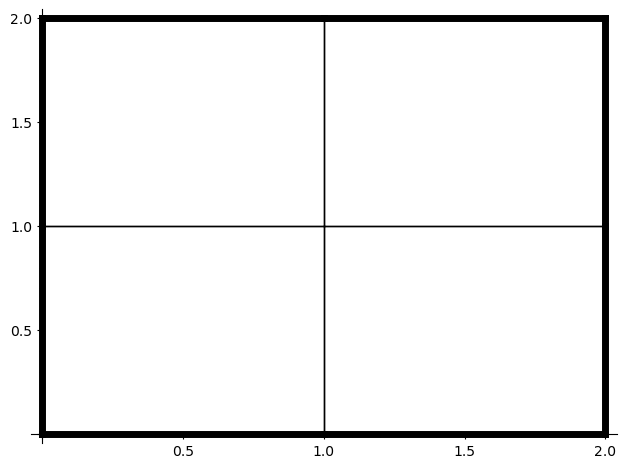

In [39]:
L = PseudoMaze((2,2))
L.plot_maze()